In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_dir = "/mnt/data/datasets/kitti/dataset/sequences/00/image_0/"

#TODO find actual camera matrix
cam_matrix = np.zeros((3,3), dtype=float)
cam_matrix[0,0] = 718.856 #fx
cam_matrix[0,2] = 607.1928 #cx
cam_matrix[1,2] = 185.2157 #cy
cam_matrix[1,1] = 718.856 #fy
cam_matrix[2,2] = 1

In [3]:
def init_flann():
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 6)
    search_params = dict(checks = 150)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann

In [4]:
def flann_ratio_match(flann, des1, des2):
    matches = flann.knnMatch(des1, des2, k=2)
    #perform lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    return good

In [5]:
def retrieve_trans(good_m, kp1, kp2):
    #translate matches to pixel cordinates... i thinl
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_m ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_m ]).reshape(-1,1,2)
    #find transformation and remve points that dont fit.
    E, mask = cv2.findEssentialMat(src_pts, dst_pts, cam_matrix, cv2.RANSAC, 0.999, 0.5)
    src_pts = src_pts[mask.ravel() == 1]
    dst_pts = dst_pts[mask.ravel() == 1]

    R1, R2, T = cv2.decomposeEssentialMat(E, src_pts, dst_pts)
    #print(T)
    #print(R2)
    return T*20, R2

In [11]:
def retrieve_trans_pts(pts1, pts2):
    E, mask = cv2.findEssentialMat(pts1, pts2, cam_matrix, cv2.RANSAC, 0.999,0.5)
    #pts1 = pts1[mask.ravel() == 1]
    #pts2 = pts1[mask.ravel() == 1]
    R1, R2, T = cv2.decomposeEssentialMat(E, pts1, pts1)
    return T, R2

In [7]:
def append_trans(pose1, pose2):
    
    pose1[0] = pose1[0] + pose1[1].dot(pose2[0])
    pose1[1] = pose2[1].dot(pose2[1])
    return pose1

In [8]:
sift = cv2.xfeatures2d.SIFT_create()
flann = init_flann()
#         T                             R
pose = [np.zeros((3,1),dtype=float), np.zeros((3,3),dtype=float)]

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (3,3),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


<IPython.core.display.Javascript object>


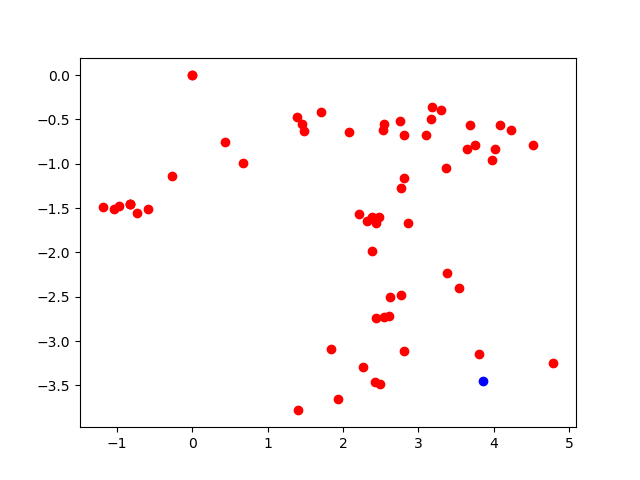

3102
2998
2914
2809
2758
2675
2626
2572
2526
2519
2507
2483
2457
2412
2403
2391
2375
2366
2350
2344
2337
2311
2285
2281
2279
2274
2274
2263
2258
2250
2246
2239
2222
2217
2215
2215
2210
2205
2202
2199
2186
2165
2162
2158
2157
2151
2151
2149
2146
2128
2029
1997
1952
1875
1860
1837
1833
1805
1726


In [14]:
xs = [0]*2
ys = [0]*2
zs = [0]*2
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

old_frame = cv2.imread(os.path.join(data_dir, str(0).zfill(6) + '.png'))
kp1, des1 = sift.detectAndCompute(old_frame, None)
pts1 = np.array([x.pt for x in kp1], dtype=np.float32)

for image_id in range(1,4541,2):
    #find keypoints in new frame
    frame = cv2.imread(os.path.join(data_dir, str(image_id).zfill(6) + '.png'))
    cv2.imshow("frame", frame)
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        break
    
    pts2, st, err = cv2.calcOpticalFlowPyrLK(old_frame, frame, pts1, None, **lk_params)
    st = st.reshape(st.shape[0])
    pts1 = pts1[st==1] # selects good points
    pts2 = pts2[st==1]

    
    #print(len(good_m))
    n_pose = retrieve_trans_pts(pts1, pts2)
    pose = append_trans(pose, n_pose)

    #check for new keyframe
    print(len(pts2))
    if len(pts2) < 550:
        pts1 = pts2.copy()
        old_frame = frame.copy()
    
    #for graph
    xs.append(pose[0][0][0])
    ys.append(pose[0][1][0])
    zs.append(pose[0][2][0])
    ax.clear()
    #print(xs)
    ax.scatter(xs[:-1],ys[:-1],color='red')
    ax.scatter(xs[-1],ys[-1], color='blue')
    fig.canvas.draw()
    
    
cv2.destroyAllWindows()

In [10]:
cv2.destroyAllWindows()


In [ ]:
show_im = True
